In [ ]:
library(rdhs)
library(survival)
library(dplyr)
library(haven)
library(tidyr)
library(ktools)
library(jsonlite)
library(magrittr)

The model transition, assuming

- if age at first sex = age at marriage: add a random noise to aam to make debut -> marriage oneway
- separated and divorced won't move to widowed, they need to remarried first

In [3]:
states <- char(virgin, debut, married, separated, divorced, widowed)
rbind(
    c(0, 1, 0, 0, 0, 0),
    c(0, 0, 1, 0, 0, 0),
    c(0, 0, 0, 1, 1, 1),
    c(0, 0, 1, 0, 0, 0),
    c(0, 0, 1, 0, 0, 0),
    c(0, 0, 1, 0, 0, 0)
) %>%
    as.matrix() %>%
    set_colnames(states) %>%
    set_rownames(states) %>% print()

          virgin debut married separated divorced widowed
virgin         0     1       0         0        0       0
debut          0     0       1         0        0       0
married        0     0       0         1        1       1
separated      0     0       1         0        0       0
divorced       0     0       1         0        0       0
widowed        0     0       1         0        0       0


Simplest data

In [4]:
ir <- readRDS('~/ir.rds')

df <- ir %>%
  transmute(
    caseid, 
    dob_cmc = v011,
    doi_cmc = v008,
    afs = v531,
    marital_status = as_factor(v501),
    marriage_age = v511
  )

df %>% count(marital_status)

marital_status,n
<fct>,<int>
never married,2284
married,9155
living together,206
widowed,486
divorced,622
not living together,467


Put into `msm` format

- never had sex individual has two records: zero and current age both in state virgin??

In [5]:
df %>%
  as_tibble() %>%
  mutate(age = (doi_cmc - dob_cmc) / 12) %>%
  select(
    id = caseid,
    age, afs, aam = marriage_age, current = marital_status
  ) %>%
  filter(afs < 97) %>%
  filter(afs == 0 | afs <= aam) %>% # let start simple
  mutate(
    afs = as.numeric(afs),
    aam = as.numeric(aam),
    aam = if_else(afs == aam, aam + runif(n(), 0.01, 0.99), aam), # same age then debut first
    S_born = 0,
    S_virgin = if_else(afs == 0, age, NA_real_),
    S_debut = if_else(afs > 0, afs, NA_real_),
    S_married = aam,
    S_divorced = if_else(current == "divorced", age, NA_real_),
    S_widowed = if_else(current == "widowed", age, NA_real_),
    S_separated = if_else(current == "not living together", age, NA_real_)
  ) %>%
  select(id, starts_with('S_')) %>%
  pivot_longer(
    -id,
    names_sep = "_",
    names_to = c(NA, "state"),
    values_to = "time"
  ) %>%
  mutate(state = if_else(state == 'born', 'virgin', state)) %>%
  mutate(
    time = as.numeric(time), 
    state = factor(state, levels = c("virgin", 'debut', "married", "separated", "divorced", "widowed"))
  ) %>%
  drop_na() %>%
  allot(female_msm)
  
female_msm %<>%
  mutate(staten = as.numeric(state))

female_msm %>% head(30)

id,state,time,staten
<chr>,<fct>,<dbl>,<dbl>
1001 1 4,virgin,0.00000,1
1001 1 4,virgin,16.91667,1
1001 5 1,virgin,0.00000,1
1001 5 1,debut,15.00000,2
1001 5 1,married,15.77929,3
1001 5 1,divorced,36.16667,5
1001 6 2,virgin,0.00000,1
1001 6 2,debut,14.00000,2
1001 6 2,married,14.94057,3


Observed transition

In [6]:
library(msm)

statetable.msm(state, id, data=female_msm)

    to
from virgin debut married separated divorced widowed
   1   1372  9759       0         0        0       0
   2      0     0    9759         0        0       0
   3      0     0       0       415      556     437

Intensity matrix - starting values

In [7]:
Qp <- rbind(
  c(0, 0.1, 0,0,0,0),
  c(0, 0, .1, 0, 0, 0),
  c(0, 0, 0, 0.1, 0.1, 0.1),
  c(0, 0, 0.1, 0, 0, 0),
  c(0, 0, 0.1, 0, 0, 0),
  c(0, 0, 0.1, 0, 0, 0)
)

Q.crude <- crudeinits.msm(staten ~ time, id,
  data = female_msm,
  qmatrix = Qp
)
Q.crude

-0.0534655,0.0534655,0.00000000,0.00000000,0.00000000,0.00000000
0.0000000,-0.5978523,0.59785229,0.00000000,0.00000000,0.00000000
0.0000000,0.0000000,-0.06750166,0.01989573,0.02665549,0.02095045
0.0000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000
0.0000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000
0.0000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000


> There is no data on the last three rows: Divorced/Widowed/Separated -> Married.

Fit the model

> note that `fnscale` need to be set in this data to avoid numerical overflow (why?)

In [9]:
msm <- msm(staten ~ time,
  subject = id, data = female_msm, qmatrix = Qp,
  control = list(fnscale = 10000)
)

Transition probability

In [10]:
pmatrix.msm(msm, t=5) %>% round(2)

        State 1 State 2 State 3 State 4 State 5 State 6
State 1    0.64    0.26    0.08    0.00    0.01    0.00
State 2    0.00    0.54    0.36    0.03    0.04    0.03
State 3    0.00    0.00    0.64    0.11    0.14    0.11
State 4    0.00    0.00    0.00    0.99    0.00    0.00
State 5    0.00    0.00    0.00    0.00    1.00    0.00
State 6    0.00    0.00    0.00    0.00    0.00    1.00

If currently virgin, 
- probability of making sexual debut 5 years from now is 0.26
- probability of married (without sexual debut) 5 years from now is 0.08

In [19]:
gd <- purrr::map_dfr(
    1:30,
    function(x) {
        pmatrix.msm(msm, t = x) %>%
            unclass() %>%
            as_tibble() %>%
            mutate(state = 1:n(), time = x)
    }
)
head(gd)

State 1,State 2,State 3,State 4,State 5,State 6,state,time
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.9156052,0.0793657,0.0048801854,4.402421e-05,5.881870e-05,4.610784e-05,1,1
0.0000000,0.8848569,0.1100521919,1.504589e-03,2.010352e-03,1.575937e-03,2,1
0.0000000,0.0000000,0.9145921180,2.523925e-02,3.372799e-02,2.644064e-02,3,1
0.0000000,0.0000000,0.0011321936,9.988317e-01,2.026069e-05,1.588257e-05,4,1
0.0000000,0.0000000,0.0003499657,4.686462e-06,9.996404e-01,4.908678e-06,5,1
0.0000000,0.0000000,0.0001572566,2.105782e-06,2.813626e-06,9.998378e-01,6,1


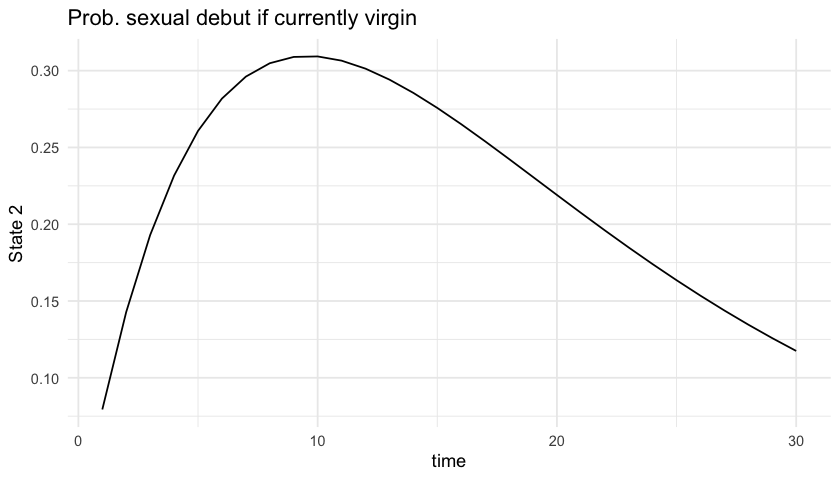

In [23]:
ktools::sizing(7, 4)
gd %>%
    filter(`State 2` != 0, state == 1) %>%
    ggplot(aes(time, `State 2`)) +
    geom_line() +
    labs(title = "Prob. sexual debut if currently virgin")

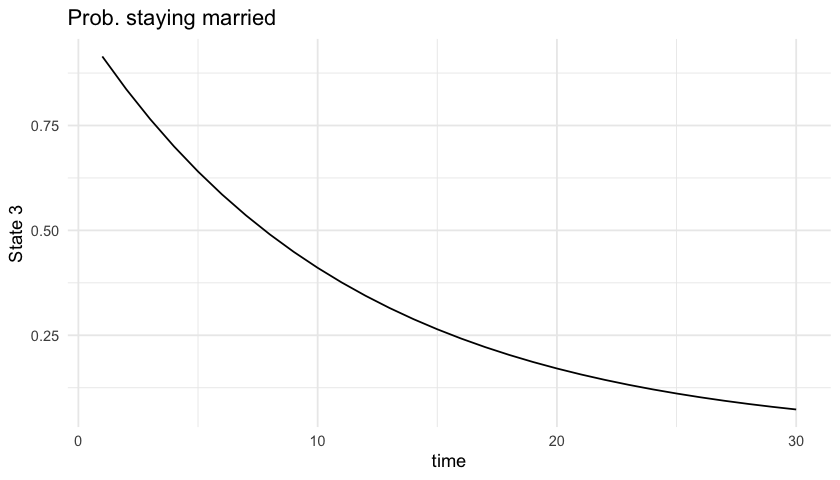

In [25]:
gd %>%
    filter(state == 3) %>%
    ggplot(aes(time, `State 3`)) +
    geom_line() +
    labs(title = "Prob. staying married")

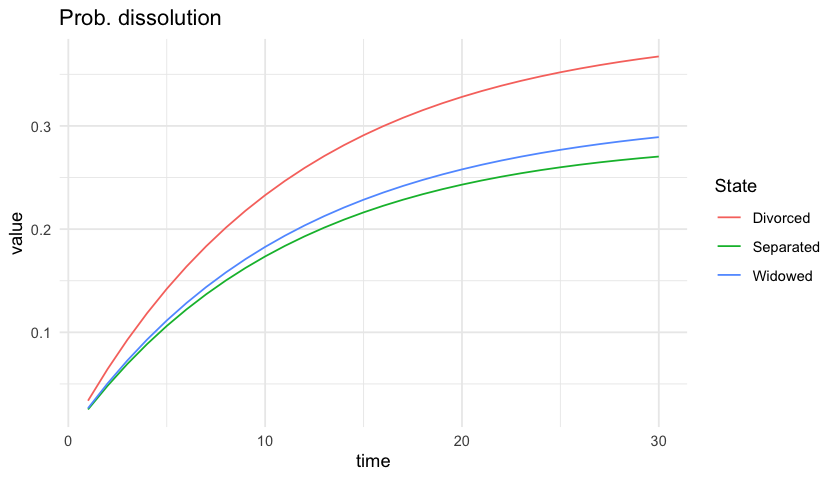

In [30]:
gd %>%
    filter(state == 3) %>%
    select(4:8) %>%
    rename_with(~ char(S_Separated, S_Divorced, S_Widowed, state, time)) %>%
    pivot_longer(starts_with('S_'), names_to = c(NA, "State"), names_sep = '_') %>%
    ggplot(aes(time, value, color = State)) +
    geom_line() +
    labs(title = "Prob. dissolution")

Average time stays within each state

$-1/q_{rr}$

In [31]:
sojourn.msm(msm)

,estimates,SE,L,U
,<dbl>,<dbl>,<dbl>,<dbl>
State 1,11.341719,0.1335713,11.082923,11.606559
State 2,8.174656,0.1081172,7.965473,8.389332
State 3,11.197936,0.3353138,10.559646,11.874807
State 4,844.450989,1026.1623982,78.020529,9139.869706
State 5,2733.064813,3280.8612418,259.919877,28738.253292
State 6,6082.904689,8318.0695437,416.999225,88733.329075


Probability that each state is next $-q_{rs}/q_{rr}$

In [32]:
pnext.msm(msm)

        State 1 State 2                State 3               
State 1 0       1.0000 (1.0000,1.0000) 0                     
State 2 0       0                      1.0000 (1.0000,1.0000)
State 3 0       0                      0                     
State 4 0       0                      1.0000 (1.0000,1.0000)
State 5 0       0                      1.0000 (1.0000,1.0000)
State 6 0       0                      1.0000 (1.0000,1.0000)
        State 4                State 5                State 6               
State 1 0                      0                      0                     
State 2 0                      0                      0                     
State 3 0.2956 (0.2724,0.3188) 0.3949 (0.3699,0.4194) 0.3095 (0.2859,0.3322)
State 4 0                      0                      0                     
State 5 0                      0                      0                     
State 6 0                      0                      0                     

Total length of stay $\int_{t_1}^{t_2} P(t)_{r, s}dt$

In [36]:
totlos.msm(msm, end  = 5)

ERROR: Error in totlos.msm(msm, end = 5): Must specify a finite end time for a model with no absorbing state


Hazard ratios for transition

In [37]:
hazard.msm(msm)

[1] "No covariates on transition intensities"